In [37]:
# MI3 - Script 02: Exploratory Analysis + Visuals
# DS4002 Group 14 | Reddit Shipping Sentiment
#
# INPUT:
#   output/shipping_comments_clean.csv  (from Script 01)
#
# OUTPUT (saved to output/figures and output/tables):
#   - counts_by_company.csv
#   - summary_mean_compound_ci.csv
#   - sentiment_share_overall.csv
#   - sentiment_share_by_company.csv
#   - figures/*.png  (plots used in MI3 presentation)
#
# NOTES:
# - This script assumes Script 01 already ran and produced the cleaned CSV.
# - This script focuses on EDA and visualization (NOT hypothesis testing).
# - Statistical tests (ANOVA, Tukey, Chi-square, Binomial) belong in Script 03.


# CELL 1) Imports
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



In [12]:
#Config (aligns with Script 01)
OUTDIR = "output"  # same as Script 01
DATA_PATH = os.path.join(OUTDIR, "shipping_comments_clean.csv")

FIG_DIR = os.path.join(OUTDIR, "figures")
TAB_DIR = os.path.join(OUTDIR, "tables")

# Create folders if they do not exist
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# Plot style (keep consistent across scripts)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("Using data:", DATA_PATH)
print("Figures ->", FIG_DIR)
print("Tables  ->", TAB_DIR)



Using data: output/shipping_comments_clean.csv
Figures -> output/figures
Tables  -> output/tables


In [26]:
#Load cleaned data (from Script 01)
df = pd.read_csv(DATA_PATH)

print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())

# Sanity checks: Script 01 should have these columns
required_cols = ["company", "text_clean"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns from Script 01 output: {missing}")




Loaded shape: (2006, 14)
Columns: ['company', 'subreddit', 'post_id', 'comment_id', 'comment_created_utc', 'comment_body', 'comment_score', 'parent_id', 'comment_created_dt', 'text_raw', 'text_clean', 'keep_basic', 'is_boilerplate', 'keep_final']


In [27]:
#Ensure sentiment columns exist (use Script 01 output if present)
# If vader_compound exists, we use it. If not, compute it here.

if "vader_compound" not in df.columns:
    print("vader_compound not found -> computing VADER scores now...")
    analyzer = SentimentIntensityAnalyzer()

    scores = df["text_clean"].astype(str).apply(analyzer.polarity_scores)
    scores_df = pd.DataFrame(list(scores))

    # Rename to our consistent naming convention
    scores_df = scores_df.rename(
        columns={
            "compound": "vader_compound",
            "pos": "vader_pos",
            "neu": "vader_neu",
            "neg": "vader_neg",
        }
    )

    df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

else:
    print("vader_compound found -> using existing sentiment columns.")

# Quick check
print(df[["company", "vader_compound"]].head())



vader_compound not found -> computing VADER scores now...
  company  vader_compound
0    USPS         -0.2960
1    USPS          0.0000
2    USPS          0.0000
3    USPS         -0.5267
4    USPS         -0.2846


In [28]:
# Basic sample size overview (counts by company)
counts = df["company"].value_counts().sort_values(ascending=False)
counts_df = counts.reset_index()
counts_df.columns = ["company", "n_comments"]

print("\nCounts by company:")
print(counts_df)

# Save table
counts_df.to_csv(os.path.join(TAB_DIR, "counts_by_company.csv"), index=False)




Counts by company:
  company  n_comments
0    USPS         793
1   FedEx         597
2     UPS         411
3     DHL         205


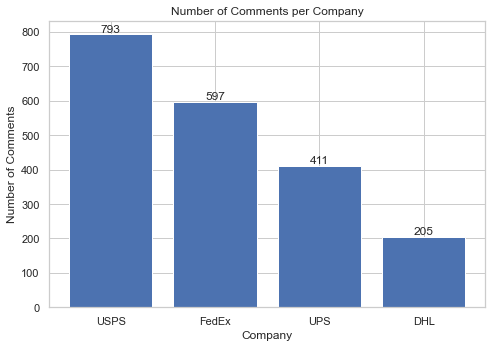

In [29]:
#lot 1 — Number of comments per company (bar chart)
plt.figure(figsize=(7, 5))

bars = plt.bar(counts_df["company"].astype(str), counts_df["n_comments"])
plt.title("Number of Comments per Company")
plt.xlabel("Company")
plt.ylabel("Number of Comments")

# Label bars with counts
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2, h, f"{int(h)}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "01_comments_per_company.png"), dpi=300)
plt.show()



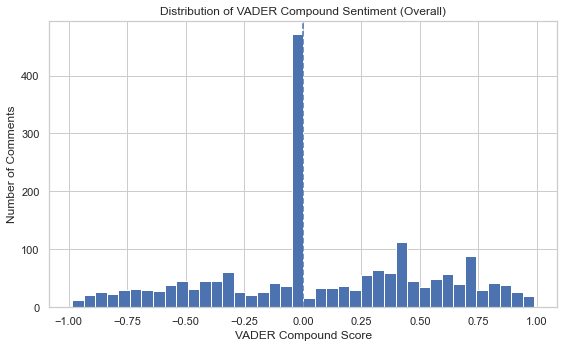

In [30]:
# Plot 2 — Overall distribution of VADER compound
plt.figure(figsize=(8, 5))

plt.hist(df["vader_compound"].dropna(), bins=40)
plt.axvline(0, linestyle="--")
plt.title("Distribution of VADER Compound Sentiment (Overall)")
plt.xlabel("VADER Compound Score")
plt.ylabel("Number of Comments")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "02_vader_compound_overall_hist.png"), dpi=300)
plt.show()



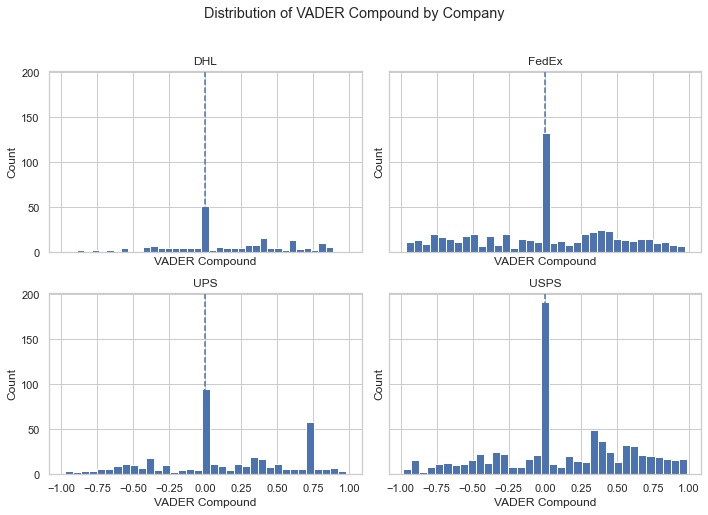

In [31]:
# Plot 3 — Distribution of VADER compound by company (faceted histograms)

# We want the same x-axis range for comparability across companies
companies = sorted(df["company"].unique().tolist())
n_comp = len(companies)

# choose a 2x2 layout if 4 companies (USPS/UPS/FedEx/DHL)
nrows = 2
ncols = int(np.ceil(n_comp / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for i, comp in enumerate(companies):
    ax = axes[i]
    vals = df.loc[df["company"] == comp, "vader_compound"].dropna()
    ax.hist(vals, bins=35)
    ax.axvline(0, linestyle="--")
    ax.set_title(comp)
    ax.set_xlabel("VADER Compound")
    ax.set_ylabel("Count")

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Distribution of VADER Compound by Company", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "03_vader_compound_hist_by_company.png"), dpi=300)
plt.show()




Mean compound summary (with 95% CI):
  company  count      mean      ci95
1   FedEx    597 -0.007858  0.038892
3    USPS    793  0.108132  0.032388
2     UPS    411  0.119616  0.045859
0     DHL    205  0.147065  0.054310


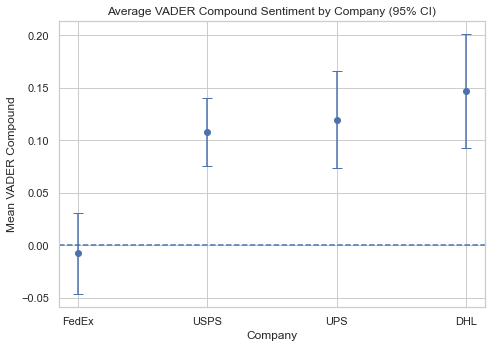

In [32]:
# Mean sentiment by company + 95% CI (for presentation)

# Normal-approx CI for mean:
# mean ± 1.96 * (std/sqrt(n))

g = df.groupby("company")["vader_compound"]
summary = g.agg(["count", "mean", "std"]).reset_index()
summary["se"] = summary["std"] / np.sqrt(summary["count"])
summary["ci95"] = 1.96 * summary["se"]

# Sort by mean so the plot reads cleanly
summary = summary.sort_values("mean")

print("\nMean compound summary (with 95% CI):")
print(summary[["company", "count", "mean", "ci95"]])

# Save table
summary.to_csv(os.path.join(TAB_DIR, "summary_mean_compound_ci.csv"), index=False)

# Plot: mean with error bars
plt.figure(figsize=(7, 5))
plt.errorbar(
    summary["company"].astype(str),
    summary["mean"],
    yerr=summary["ci95"],
    fmt="o",
    capsize=5
)
plt.axhline(0, linestyle="--")
plt.title("Average VADER Compound Sentiment by Company (95% CI)")
plt.xlabel("Company")
plt.ylabel("Mean VADER Compound")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "04_mean_compound_95ci.png"), dpi=300)
plt.show()


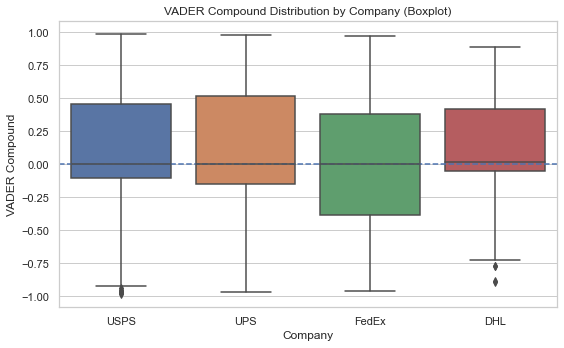

In [33]:
# Boxplot of compound by company (shows spread/outliers)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="company", y="vader_compound")
plt.axhline(0, linestyle="--")
plt.title("VADER Compound Distribution by Company (Boxplot)")
plt.xlabel("Company")
plt.ylabel("VADER Compound")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "05_boxplot_compound_by_company.png"), dpi=300)
plt.show()



In [38]:
# Create 3-class sentiment labels (VADER standard thresholds)
# VADER standard:
#   compound >=  0.05 => Positive
#   compound <= -0.05 => Negative
#   else             => Neutral

def label_sentiment(compound_score: float) -> str:
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["vader_compound"].apply(label_sentiment)

# Overall sentiment share
overall_share = df["sentiment_label"].value_counts(normalize=True).reset_index()
overall_share.columns = ["sentiment_label", "share"]

print("\nOverall sentiment share:")
print(overall_share)

overall_share.to_csv(os.path.join(TAB_DIR, "sentiment_share_overall.csv"), index=False)




Overall sentiment share:
  sentiment_label     share
0        Positive  0.447159
1        Negative  0.310070
2         Neutral  0.242772


In [35]:
# Sentiment share by company (table)
tab = pd.crosstab(df["company"], df["sentiment_label"], normalize="index")

# Ensure consistent column order (even if one category is missing)
for col in ["Negative", "Neutral", "Positive"]:
    if col not in tab.columns:
        tab[col] = 0.0
tab = tab[["Negative", "Neutral", "Positive"]]

print("\nSentiment share by company:")
print(tab)

tab.to_csv(os.path.join(TAB_DIR, "sentiment_share_by_company.csv"))




Sentiment share by company:
sentiment_label  Negative   Neutral  Positive
company                                      
DHL              0.253659  0.258537  0.487805
FedEx            0.373534  0.232831  0.393635
UPS              0.279805  0.240876  0.479319
USPS             0.292560  0.247163  0.460277


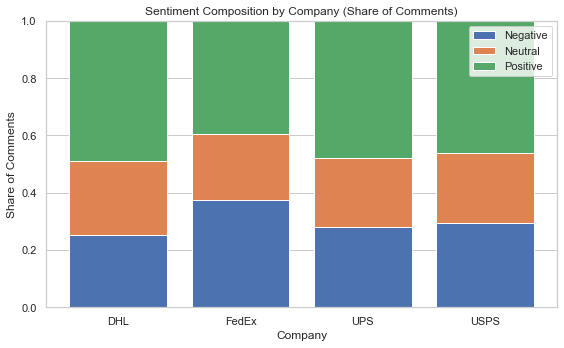

In [36]:
# Plot - Stacked bar: sentiment composition by company

plt.figure(figsize=(8, 5))

x = np.arange(len(tab.index))
bottom = np.zeros(len(tab.index))

for col in tab.columns:
    vals = tab[col].values
    plt.bar(x, vals, bottom=bottom, label=col)
    bottom += vals

plt.xticks(x, tab.index.astype(str))
plt.title("Sentiment Composition by Company (Share of Comments)")
plt.xlabel("Company")
plt.ylabel("Share of Comments")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "06_sentiment_composition_stacked.png"), dpi=300)
plt.show()


In [39]:
# n, mean, median, std for compound by company

eda_table = df.groupby("company")["vader_compound"].agg(
    n="count",
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max"
).reset_index()

print("\nEDA table (compound by company):")
print(eda_table)

eda_table.to_csv(os.path.join(TAB_DIR, "eda_compound_summary_by_company.csv"), index=False)


EDA table (compound by company):
  company    n      mean  median       std     min     max
0     DHL  205  0.147065   0.015  0.396733 -0.8885  0.8860
1   FedEx  597 -0.007858   0.000  0.484835 -0.9626  0.9732
2     UPS  411  0.119616   0.000  0.474341 -0.9706  0.9786
3    USPS  793  0.108132   0.000  0.465337 -0.9850  0.9878


In [40]:

# Final checkpoint message

print("Saved figures to:", FIG_DIR)
print("Saved tables  to:", TAB_DIR)

Saved figures to: output/figures
Saved tables  to: output/tables
